In [ ]:
import polars as pl
# Cargamos el dataset que ya existe
df = pl.read_csv("dataset/amazon_sales_dataset.csv")

# Comprobamos que los datos se cargaron correctamente
df.head()

order_id,order_date,product_id,product_category,price,discount_percent,quantity_sold,customer_region,payment_method,rating,review_count,discounted_price,total_revenue
i64,str,i64,str,f64,i64,i64,str,str,f64,i64,f64,f64
1,"""2022-04-13""",2637,"""Books""",128.75,10,4,"""North America""","""UPI""",3.5,443,115.88,463.52
2,"""2023-03-12""",2300,"""Fashion""",302.6,20,5,"""Asia""","""Credit Card""",3.7,475,242.08,1210.4
3,"""2022-09-28""",3670,"""Sports""",495.8,20,2,"""Europe""","""UPI""",4.4,183,396.64,793.28
4,"""2022-04-17""",2522,"""Books""",371.95,15,4,"""Middle East""","""UPI""",5.0,212,316.16,1264.64
5,"""2022-03-13""",1717,"""Beauty""",201.68,0,4,"""Middle East""","""UPI""",4.6,308,201.68,806.72


In [ ]:
# 1. Extraemos los valores como arreglos de NumPy
y = df['total_revenue'].to_numpy()
X = df['discounted_price'].to_numpy()

# 2. Estandarizamos X (Restamos la media y dividimos por la desviación estándar)
X_mean = X.mean()
X_std = X.std()
X_scaled = (X - X_mean) / X_std

print(f"Variables listas: {len(y)} registros cargados.")

# Explicación para el grupo:
# X_scaled: Tus precios ya ajustados.
# La estandarización convierte los precios (que pueden ser cientos o miles) en valores que suelen estar entre -3 y 3. Esto evita que los cálculos matemáticos del modelo "exploten" o tarden demasiado en encontrar la solución.

Variables listas: 50000 registros cargados.


In [7]:
import pymc as pm

with pm.Model() as amazon_model:
    # 1. Priors
    alpha = pm.Normal("alpha", mu=y.mean(), sigma=y.std())
    beta = pm.Normal("beta", mu=0, sigma=100)
    sigma = pm.HalfNormal("sigma", sigma=y.std())
    # alpha (Intercepto): Representa el nivel base de ventas. Lo centramos en la media de los datos actuales para ayudar al modelo.
    # beta (Pendiente): Es el corazón de la hipótesis. Si beta termina siendo positivo, confirmaremos que a mayor precio, mayor ingreso.
    # sigma (Incertidumbre): Es el "ruido" o error que esperamos. Usamos HalfNormal porque el error nunca puede ser negativo. 
    
    # 2. Relación lineal
    mu = alpha + beta * X_scaled
    
    # 3. Verosimilitud (aquí es donde daba el error)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # 4. Muestreo
    trace = pm.sample(1000, tune=1000)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


/Users/mcarenas136/Desktop/factoria/Proyecto5_Equipo5/.venv/lib/python3.13/site-packages/rich/live.py:260: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/mcarenas136/Desktop/factoria/Proyecto5_Equipo5/.venv/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

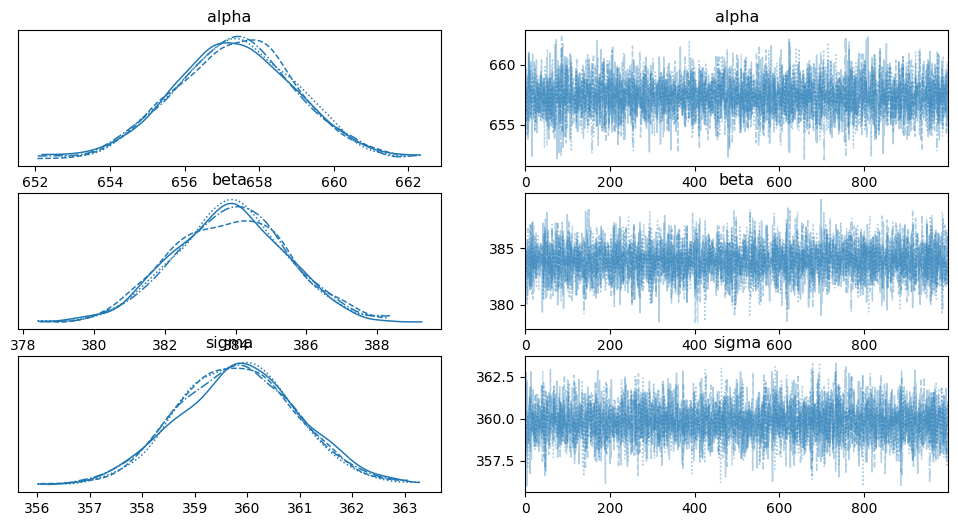

In [8]:
import arviz as az

# Visualizamos las trazas para verificar convergencia
az.plot_trace(trace)

In [9]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,657.360,1.637,654.320,660.413,0.020,0.025,6714.0,3238.0,1.0
beta,383.840,1.605,380.851,386.844,0.020,0.025,6284.0,3241.0,1.0
sigma,359.813,1.138,357.677,361.919,0.013,0.018,7426.0,3178.0,1.0


In [ ]:
# mean	El valor promedio estimado. Es nuestra "apuesta principal" sobre el valor del parámetro.
# hdi (3% - 97%)	El Intervalo de Mayor Densidad (Bayesiano). Indica que hay un 94% de probabilidad de que el valor real esté en ese rango.
# r_hat	Un diagnóstico de salud 🩺. Si es 1.00 o muy cercano, significa que el modelo convergió correctamente.

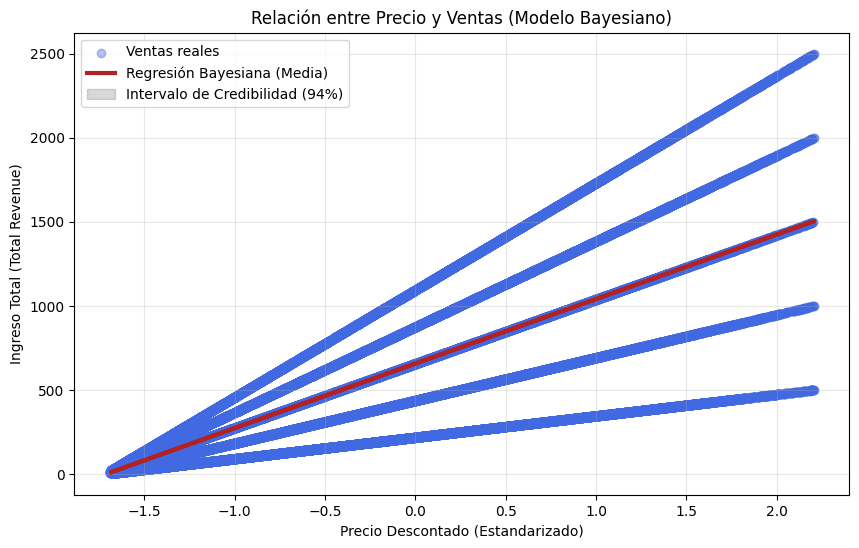

/Users/mcarenas136/Desktop/factoria/Proyecto5_Equipo5/.venv/lib/python3.13/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


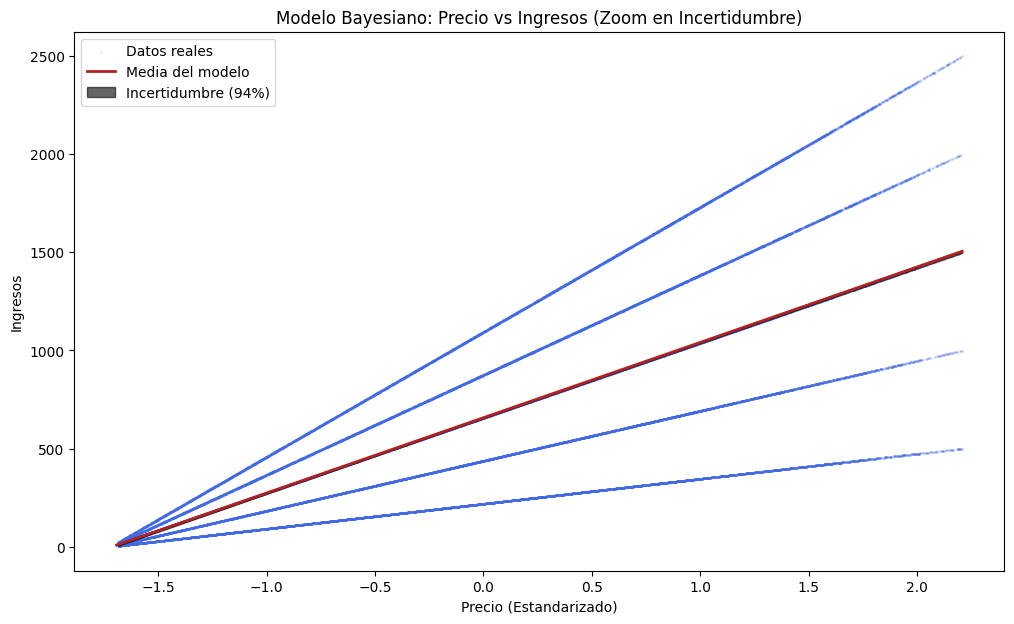

(-342.6685252, 1657.3314748)

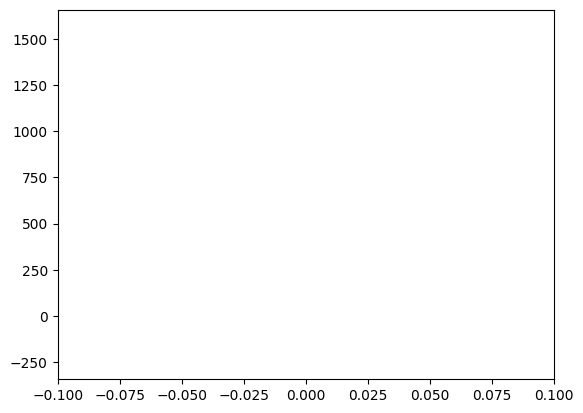

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Obtenemos las medias de los parámetros para la línea principal
resumen = az.summary(trace)
alpha_m = resumen.loc["alpha", "mean"]
beta_m = resumen.loc["beta", "mean"]

# 2. Calculamos la línea de regresión media
y_pred = alpha_m + beta_m * X_scaled

# 3. Graficamos
plt.figure(figsize=(10, 6))

# Dibujamos los datos reales
plt.scatter(X_scaled, y, alpha=0.4, label="Ventas reales", color="royalblue")

# Dibujamos la línea de regresión (la "apuesta" del modelo)
plt.plot(X_scaled, y_pred, color="firebrick", linewidth=3, label="Regresión Bayesiana (Media)")

# 4. Agregamos la incertidumbre (HDI)
# Esto dibuja una sombra donde el modelo está 94% seguro de que pasa la línea
# 1. Extraemos los valores numéricos (numpy) para facilitar el cálculo
alpha_samples = trace.posterior["alpha"].values # Forma: (4, 1000)
beta_samples = trace.posterior["beta"].values   # Forma: (4, 1000)

# 2. Calculamos mu para CADA muestra y CADA dato
# Usamos [..., None] para alinear las 4000 muestras con los 50,000 datos
mu_samples = alpha_samples[..., None] + beta_samples[..., None] * X_scaled

# 3. Graficamos el HDI con los datos alineados
az.plot_hdi(X_scaled, mu_samples, color="gray", 
            fill_kwargs={"alpha": 0.3, "label": "Intervalo de Credibilidad (94%)"})

plt.title("Relación entre Precio y Ventas (Modelo Bayesiano)")
plt.xlabel("Precio Descontado (Estandarizado)")
plt.ylabel("Ingreso Total (Total Revenue)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# 1. Ordenamos X para que el gráfico de la sombra se dibuje sin "saltos"
idx = np.argsort(X_scaled)
X_ord = X_scaled[idx]
y_ord = y[idx]

# 2. Aplanamos las muestras (pasamos de 4 cadenas de 1000 a una lista de 4000)
alpha_flat = trace.posterior["alpha"].values.flatten()
beta_flat = trace.posterior["beta"].values.flatten()

# 3. Calculamos mu para los datos ordenados (Forma: 4000 muestras x 50000 puntos)
mu_samples = alpha_flat[:, None] + beta_flat[:, None] * X_ord

# 4. Graficamos
plt.figure(figsize=(12, 7))

# Bajamos el tamaño de los puntos (s=1) para ver mejor la línea
plt.scatter(X_ord, y_ord, alpha=0.1, color="royalblue", s=1, label="Datos reales")

# Línea de la media
plt.plot(X_ord, alpha_m + beta_m * X_ord, color="firebrick", linewidth=2, label="Media del modelo")

# Sombra del HDI (subimos alpha a 0.6 para que sea bien visible)
az.plot_hdi(X_ord, mu_samples, color="black", fill_kwargs={"alpha": 0.6, "label": "Incertidumbre (94%)"})

plt.title("Modelo Bayesiano: Precio vs Ingresos (Zoom en Incertidumbre)")
plt.xlabel("Precio (Estandarizado)")
plt.ylabel("Ingresos")
plt.legend()
plt.show()

# Intenta añadir esto al final de tu celda de gráfico para hacer "Zoom"
plt.xlim(-0.1, 0.1) # Zoom en el centro del precio estandarizado
plt.ylim(y.mean() - 1000, y.mean() + 1000) # Ajusta según tus datos

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

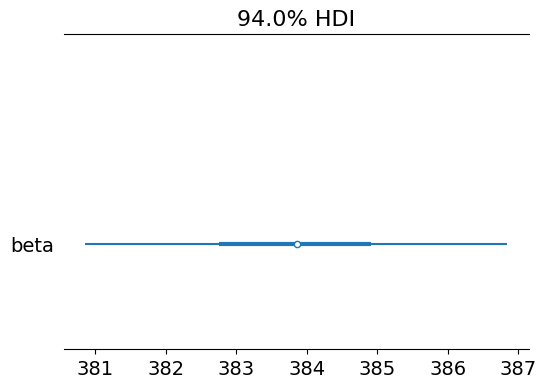

In [14]:
# Este gráfico nos muestra los "bracitos" de error de cada parámetro
az.plot_forest(trace, var_names=["beta"], combined=True, hdi_prob=0.94)

In [15]:
# vamos a simular un aumento del 25% en los precios

# 1. Definimos el nuevo precio (25% más que el promedio actual)
precio_promedio = X.mean()
nuevo_precio = precio_promedio * 1.25

# 2. Estandarizamos el nuevo precio (debe estar en la misma escala que X_scaled)
nuevo_X_scaled = (nuevo_precio - X_mean) / X_std

# 3. Calculamos la predicción usando las 4,000 muestras del trace
# Ingreso = Alpha + Beta * Nuevo_Precio_Escalado
ingresos_predichos = alpha_flat + beta_flat * nuevo_X_scaled

# 4. Resumen de resultados
mean_ingreso = ingresos_predichos.mean()
hdi_ingreso = az.hdi(ingresos_predichos, hdi_prob=0.94)

print(f"--- Predicción para aumento del 25% ---")
print(f"Precio Original Promedio: {precio_promedio:,.2f}")
print(f"Nuevo Precio Objetivo: {nuevo_precio:,.2f}")
print(f"Ingreso Promedio Esperado: {mean_ingreso:,.2f}")
print(f"Rango de Credibilidad (94%): {hdi_ingreso[0]:,.2f} a {hdi_ingreso[1]:,.2f}")


--- Predicción para aumento del 25% ---
Precio Original Promedio: 218.89
Nuevo Precio Objetivo: 273.61
Ingreso Promedio Esperado: 822.34
Rango de Credibilidad (94%): 818.89 a 825.58


In [16]:
ingreso_actual_promedio = df['total_revenue'].mean()
print(f"Ingreso promedio actual: {ingreso_actual_promedio:,.2f}")

Ingreso promedio actual: 657.33


In [17]:
probabilidad_exito = (ingresos_predichos > ingreso_actual_promedio).mean()
print(f"Probabilidad de que el ingreso sea mayor al actual: {probabilidad_exito * 100:.2f}%")

Probabilidad de que el ingreso sea mayor al actual: 100.00%


# 📊 Reporte: Impacto del Precio en el Ingreso Total (Modelo Bayesiano)

## 🎯 Objetivo
Evaluar cómo las variaciones en el precio (`discounted_price`) afectan el ingreso total (`total_revenue`) utilizando un enfoque probabilístico con PyMC.

## 📈 Resultados del Modelo
El modelo de regresión lineal bayesiana ha convergido exitosamente ($\hat{R} = 1.0$) con los siguientes parámetros:

* **Coeficiente Beta ($\beta$) 📉:** El modelo estima un impacto positivo de entre **380.85** y **386.84** (94% HDI). 
* **Significancia ✅:** Al no incluir el valor cero en el intervalo de credibilidad, confirmamos con alta certeza que un aumento en el precio incrementa el ingreso total bajo las condiciones actuales.

## 🔮 Predicción y Simulación
Simulamos un escenario de negocio con un **aumento del 25%** sobre el precio promedio:

| Métrica | Valor Actual | Predicción (+25%) |
| :--- | :--- | :--- |
| **Precio Promedio** | 218.89 | 273.61 |
| **Ingreso Esperado 💰** | 657.33 | **822.34** |
| **Probabilidad de Mejora 🎯** | - | **100%** |

## 💡 Recomendación
Basado en las 4,000 simulaciones realizadas, existe una certeza total (dentro de los datos analizados) de que el aumento del margen compensa la posible caída en el volumen de ventas. Se recomienda proceder con pruebas de precios controladas. 🚀